## Часть 1. Парсинг (10 баллов)

Мы предлагаем вам распарсить часть данных litres.ru — а именно часть про книги, имеющие отношение к программированию.

Они находятся в этом каталоге: https://www.litres.ru/genre/programmirovanie-5272/

Вам нужно собрать датасет о книгах с первых 40-ти страниц каталога (около 960 книг.)
*Подсказка.* Можете начать с исследования html кода этой страницы.

Вам необходимо собрать датасет, содержащий следующие данные:
* name: название книги
* author: автор
* link: ссылка на книгу
* rating: рейтинг по 5-балльной шкале
* rating_count: количество оценок
* review_count: количество отзывов
* pages_count: объем (число страниц)
* price: цена
* text_reviews: тексты отзывов: список строк
* age: возрастное ограничение
* year: год написания

В дальнейшем вам нужно будет анализировать полученный у вас датасет.

Если у вас не получилось спарсить датасет, воспользуйтесь для последующих пунктов готовым датасетом: https://disk.yandex.ru/d/2UZet2-qxRxF6Q

 Так вы сможете получить баллы за вторую часть.

(Датасет неидеален, с ним придется поработать!)

**Парсите "вежливо": используйте time.sleep() не меньше 1-2 секунд между запросами к сайту!**

In [2]:
from bs4 import BeautifulSoup
from unicodedata import normalize
import requests
import time
import csv
import tqdm

In [3]:
URL_TEMPLATE = "https://www.litres.ru/genre/programmirovanie-5272/?page={}"
BASE_URL = "https://www.litres.ru"
PAGE_RANGE = range(1, 40)

CARD_CLASS_NAME = "ArtDefault_wrapper__VmWpW ArtDefault_wrapper__adaptive__VW5z0"
CONTAINER_CLASS_NAME = "ArtDefault_container__0yjZl"
PAGINATOR_CLASS_NAME = "Paginator_container__XXcz8"
COMMENT_CLASS_NAME = "Comment_reviewText__PEkHn"
BOOK_TITLE_CLASS_NAME = "BookCard_book__mainInfo__title___nFS4"
BOOK_REVIEW_CLASS_NAME = "BookFactoids_primary__TVFhL"
AUTHOR_NAME_CLASS_NAME = "BookAuthor_author__name__ORVlE"

In [4]:
def parse_everything():
    for page in tqdm.tqdm(PAGE_RANGE):
        yield from parse_page(page)


def parse_page(number: int):
    page_content = requests.get(URL_TEMPLATE.format(number)).text
    return parse_gallery(BeautifulSoup(page_content, "html.parser"))


def parse_gallery(soup: BeautifulSoup):
    for card in soup.findAll("div", class_=CARD_CLASS_NAME):
        try:
            link = (
                BASE_URL
                + card.find("div", attrs={"data-testid": "art__cover"}).a.attrs["href"]
            )
            print("Parsing", link, "...")
            if "audiobook" in link:
                print("Skipping audiobook")
                continue
            full_page_text = requests.get(link).text
            review_page_text = requests.get(link + f"otzivi").text
            yield *parse_full_page(
                BeautifulSoup(full_page_text, "html.parser")
            ), link, [
                *parse_reviews(link, BeautifulSoup(review_page_text, "html.parser"))
            ]
            time.sleep(1.5)
        except Exception as e:
            print("Failure to parse. Continue", e)


def parse_count_review_pages(soup: BeautifulSoup):
    paginator = soup.find("div", PAGINATOR_CLASS_NAME)
    if paginator is None:
        return 1
    paginator_children = [*paginator.children]
    return paginator_children[-1].a.text


def parse_review_page(soup: BeautifulSoup):
    for comment in soup.findAll("div", class_=COMMENT_CLASS_NAME):
        yield "".join(comment.findAll(string=True))


def parse_reviews(base_url: str, soup: BeautifulSoup):
    pages_count = parse_count_review_pages(soup)
    for page in range(pages_count):
        review_page_text = requests.get(base_url + f"otzivi/?page={page + 1}").text
        time.sleep(1.5)
        yield from parse_review_page(BeautifulSoup(review_page_text, "html.parser"))


def parse_full_page(soup: BeautifulSoup):
    def by_testid(testid: str, element: str = None):
        return soup.find(attrs={"data-testid": testid})

    name = soup.find("h1", class_=BOOK_TITLE_CLASS_NAME).text
    price = float(
        normalize(
            "NFKD", by_testid("book-sale-block__discount--art--price").text[:-1]
        ).replace(" ", "").replace(",", ".")
    )

    rating_root = by_testid("book-factoids__rating")
    rating_count = int(
        rating_root.find(attrs={"itemprop": "ratingCount"}).attrs["content"]
    )
    rating = float(rating_root.find(attrs={"itemprop": "ratingValue"}).attrs["content"])

    review_count = int(
        by_testid("book-factoids__reviews")
        .find("div", class_=BOOK_REVIEW_CLASS_NAME)
        .span.text
    )

    volume_root = by_testid("book-volume__wrapper")
    volume_root_children = [*volume_root.children]
    pages_count = int(volume_root_children[0].text.split()[1])
    age = volume_root_children[-1].text

    characteristics_wrapper = by_testid("book-characteristics__wrapper")
    year = None
    for child in characteristics_wrapper.children:
        if "Дата написания" in child.div.span.text:
            year = [*child.children][-1].text
    if soup.find("a", class_=AUTHOR_NAME_CLASS_NAME):
        author = soup.find("a", class_=AUTHOR_NAME_CLASS_NAME).div.div.span.text
    else:
        author = None
    return (
        name,
        price,
        rating_count,
        rating,
        review_count,
        pages_count,
        age,
        author,
        year,
    )


In [5]:
with open('litres_programming_data.csv','w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(("", "name", "price", "rating_count", "rating", "review_count", "pages_count", "age", "author", "year", "link", "text_of_reviews"))
    for i, data in enumerate(parse_everything()):
      csv_out.writerow((i, *data))

  0%|          | 0/39 [00:00<?, ?it/s]

Parsing https://www.litres.ru/book/toni-geddis-32491161/nachinaem-programmirovat-na-python-68998912/ ...
Parsing https://www.litres.ru/book/vlad-hononov/izuchaem-ddd-predmetno-orientirovannoe-proektirovanie-70920895/ ...
Parsing https://www.litres.ru/book/aleks-suy/system-design-podgotovka-k-slozhnomu-intervu-67193183/ ...
Parsing https://www.litres.ru/book/martin-kleppman-1733/vysokonagruzhennye-prilozheniya-programmirovanie-mass-39100996/ ...
Parsing https://www.litres.ru/book/dzheyd-karter/python-biblioteki-70323379/ ...
Parsing https://www.litres.ru/book/dzheyd-karter/neyroseti-nachalo-69188950/ ...
Parsing https://www.litres.ru/book/anna-bosova/informatika-7-klass-68294027/ ...
Parsing https://www.litres.ru/book/endru-tanenbaum/arhitektura-komputera-66738078/ ...
Parsing https://www.litres.ru/book/dzhon-bodner/go-idiomy-i-patterny-proektirovaniya-pdf-epub-67893687/ ...
Parsing https://www.litres.ru/book/robert-s-martin/chistyy-kod-sozdanie-analiz-i-refaktoring-pdf-epub-6444478/ ..

  3%|▎         | 1/39 [01:40<1:03:33, 100.34s/it]

Parsing https://www.litres.ru/book/mark-richards-326443/fundamentalnyy-podhod-k-programmnoy-arhitekture-patte-69434368/ ...
Parsing https://www.litres.ru/book/vladimir-horikov/principy-unit-testirovaniya-pdf-epub-64083637/ ...
Parsing https://www.litres.ru/book/slava-gris/sdelay-videoigru-odin-i-ne-svihnis-68745309/ ...
Parsing https://www.litres.ru/book/dzhon-vlissides/patterny-obektno-orientirovannogo-proektirovaniya-64073196/ ...
Parsing https://www.litres.ru/book/don-griffits/head-first-programmirovanie-dlya-android-na-kotlin-69932284/ ...
Parsing https://www.litres.ru/book/bendzhamin-dzh-evans/java-dlya-opytnyh-razrabotchikov-pdf-epub-70870265/ ...
Parsing https://www.litres.ru/book/patrisha-foster/programmirovanie-na-python-s-nulya-uchimsya-dumat-kak-prog-68459110/ ...
Parsing https://www.litres.ru/book/teyva-harshani/100-oshibok-go-i-kak-ih-izbezhat-epub-69932935/ ...
Parsing https://www.litres.ru/book/anna-bosova/informatika-7-9-klassy-komputernyy-praktikum-66644798/ ...
Parsin

  5%|▌         | 2/39 [03:17<1:00:43, 98.48s/it] 

Parsing https://www.litres.ru/book/klarens-ho/spring-5-dlya-professionalov-48613790/ ...
Parsing https://www.litres.ru/book/e-u-hrustaleva/rasshireniya-konfiguraciy-adaptaciya-prikladnyh-resheniy-s-40911721/ ...
Parsing https://www.litres.ru/book/zhamak-dehgani/sovremennyy-podhod-k-programmnoy-arhitekture-slozhnye-kompr-69932209/ ...
Parsing https://www.litres.ru/book/ueyn-vinston/biznes-modelirovanie-i-analiz-dannyh-reshenie-aktualnyh-zadac-64069201/ ...
Parsing https://www.litres.ru/book/mareyn-haverbeke/vyrazitelnyy-javascript-sovremennoe-veb-programmirovanie-50447564/ ...
Parsing https://www.litres.ru/book/dzheyd-karter/neyroseti-obrabotka-audiodannyh-69858871/ ...
Parsing https://www.litres.ru/book/olga-nazina/test-dizayn-prakticheskoe-rukovodstvo-dlya-nachinauschih-69842647/ ...
Parsing https://www.litres.ru/book/dzhordzh-hayneman/algoritmy-s-primerami-na-python-pdf-epub-69598561/ ...
Parsing https://www.litres.ru/book/vladimir-dronov/python-3-i-pyqt-6-razrabotka-prilozheniy-6899

  8%|▊         | 3/39 [05:02<1:00:55, 101.54s/it]

Parsing https://www.litres.ru/book/anna-bosova/informatika-bazovyy-uroven-10-11-klassy-komputernyy-praktikum-66644828/ ...
Parsing https://www.litres.ru/book/andreas-m-antonopulos/osvaivaem-bitkoin-programmirovanie-blokcheyna-44867821/ ...
Parsing https://www.litres.ru/book/kent-bek/ekstremalnoe-programmirovanie-razrabotka-cherez-testirovanie-164068/ ...
Parsing https://www.litres.ru/book/mark-vinteringem/testirovanie-veb-api-epub-70504714/ ...
Parsing https://www.litres.ru/book/mattias-nobak/obekty-stilnoe-oop-pdf-epub-69166270/ ...
Parsing https://www.litres.ru/book/dag-tarnbull-1976644/relevantnyy-poisk-s-ispolzovaniem-elasticsearch-i-sol-45670040/ ...
Parsing https://www.litres.ru/audiobook/dzhon-sonmez/karera-v-it-kak-nayti-rabotu-prokachat-navyki-i-stat-krutym-r-69436486/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/aleks-suy/system-design-mashinnoe-obuchenie-podgotovka-k-slozhnomu-intervu-70415851/ ...
Parsing https://www.litres.ru/book/raznoe-4340152/algoritmy-v-za

 10%|█         | 4/39 [06:48<1:00:14, 103.28s/it]

Parsing https://www.litres.ru/book/dzhoanna-yablonski/znakomstvo-s-python-epub-68677476/ ...
Parsing https://www.litres.ru/book/hit-haskins/rukovodstvo-po-sozdaniu-igrovyh-mirov-roblox-ischerpyvauschiy-67974270/ ...
Parsing https://www.litres.ru/book/mihalis-cukalos-2771/golang-dlya-profi-sozdaem-professionalnye-utility-par-69932944/ ...
Parsing https://www.litres.ru/book/dzhey-vengrou/prikladnye-struktury-dannyh-i-algoritmy-prokachivaem-navyki-69932068/ ...
Parsing https://www.litres.ru/book/stanislav-chernyshev/osnovy-dart-pdf-epub-70870241/ ...
Parsing https://www.litres.ru/book/dzheyd-karter/svertochnye-neyroseti-70965715/ ...
Parsing https://www.litres.ru/book/anatoliy-postolit/python-django-i-bootstrap-dlya-nachinauschih-70920859/ ...
Parsing https://www.litres.ru/book/tim-maknamara/rust-v-deystvii-69842617/ ...
Parsing https://www.litres.ru/book/kennedi-berman/osnovy-python-dlya-data-science-pdf-epub-69154048/ ...
Parsing https://www.litres.ru/book/dmitriy-ryaboy/readme-surovye-

 13%|█▎        | 5/39 [08:36<59:28, 104.95s/it]  

Parsing https://www.litres.ru/book/raznoe-4340152/algoritmy-s-nulya-pdf-epub-70870256/ ...
Parsing https://www.litres.ru/book/a-a-salahova/arduino-r-polnyy-uchebnyy-kurs-ot-igry-k-inzhenernomu-proektu-56509900/ ...
Parsing https://www.litres.ru/book/vladston-ferreyra-fi/teoreticheskiy-minimum-po-computer-science-vse-chto-n-34946144/ ...
Parsing https://www.litres.ru/book/dzh-hank-reynvoter/kak-pasti-kotov-nastavlenie-dlya-programmistov-rukovody-167876/ ...
Parsing https://www.litres.ru/book/kayl-simpson/vy-poka-esche-ne-znaete-js-poznakomtes-javascript-pdf-epub-66658092/ ...
Parsing https://www.litres.ru/book/alan-kuper/psihbolnica-v-rukah-pacientov-alan-kuper-ob-interfeysah-31736385/ ...
Parsing https://www.litres.ru/book/martin-fauler/uml-osnovy-3-e-izdanie-24500318/ ...
Parsing https://www.litres.ru/book/dmitriy-kolesnichenko/razrabotka-veb-prilozheniy-na-php-8-70980292/ ...
Parsing https://www.litres.ru/book/dzhozef-u/yadro-cortex-m3-kompanii-arm-polnoe-rukovodstvo-48411055/ ...
Pa

 15%|█▌        | 6/39 [10:34<1:00:07, 109.32s/it]

Parsing https://www.litres.ru/book/yan-poynter-27650377/programmiruem-s-pytorch-sozdanie-prilozheniy-glubokog-64082211/ ...
Parsing https://www.litres.ru/book/ues-makkinni-10688670/python-i-analiz-dannyh-22805830/ ...
Parsing https://www.litres.ru/book/timur-mashnin-301845/tehnologiya-hraneniya-i-obrabotki-bolshih-dannyh-hado-65077172/ ...
Parsing https://www.litres.ru/book/timur-mashnin-30184546/osnovy-programmirovaniya-s-java-67715945/ ...
Parsing https://www.litres.ru/book/tom-long/horoshiy-kod-plohoy-kod-patterny-i-antipatterny-masterstva-70297336/ ...
Parsing https://www.litres.ru/book/robertu-ieruzalimski/programmirovanie-na-yazyke-lua-9998731/ ...
Parsing https://www.litres.ru/book/kori-althoff/sam-sebe-programmist-kak-nauchitsya-programmirovat-i-ustroits-33397888/ ...
Parsing https://www.litres.ru/book/dzherard-mesarosh/shablony-testirovaniya-xunit-refaktoring-koda-testov-48637685/ ...
Parsing https://www.litres.ru/book/ched-fauler/programmist-fanatik-9535814/ ...
Parsing https

 18%|█▊        | 7/39 [12:37<1:00:37, 113.68s/it]

Parsing https://www.litres.ru/book/timur-kazancev/iskusstvennyy-intellekt-i-mashinnoe-obuchenie-osnovy-progra-59162107/ ...
Parsing https://www.litres.ru/audiobook/aleksandr-torgovkin/testirovanie-videoigr-ili-legkiy-sposob-popast-v-geymd-70918156/ ...
Skipping audiobook
Parsing https://www.litres.ru/audiobook/nikita-zaycev-aka-wildha/put-1s-razrabotki-ne-spesha-effektivno-i-pravilno-70789105/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/dzheremi-gibson-bond/unity-i-s-geymdev-ot-idei-do-realizacii-pdf-epub-64085991/ ...
Parsing https://www.litres.ru/book/dzhosh-lospinozo/c-dlya-profi-64821742/ ...
Parsing https://www.litres.ru/book/ilya-leonidovich-hohlov/samouchitel-kurs-sql-bazy-dannyh-oracle-69188986/ ...
Parsing https://www.litres.ru/book/el-sveygart/python-chistyy-kod-dlya-prodolzhauschih-67781789/ ...
Parsing https://www.litres.ru/book/endru-trask-21142618/grokaem-glubokoe-obuchenie-pdf-epub-48613333/ ...
Parsing https://www.litres.ru/book/uill-kurt-30699932/bayesovs

 21%|██        | 8/39 [14:21<57:11, 110.70s/it]  

Parsing https://www.litres.ru/book/gevin-king-21051037/java-persistence-api-i-hibernate-48411103/ ...
Parsing https://www.litres.ru/book/lorens-lars-svekis/javascript-s-nulya-do-profi-pdf-epub-69434440/ ...
Parsing https://www.litres.ru/book/dzhordzh-maunt/pogruzhenie-v-analitiku-dannyh-ot-excel-k-python-i-r-70297342/ ...
Parsing https://www.litres.ru/book/denis-vladimirovich-golikov/python-dlya-unyh-programmistov-68999056/ ...
Parsing https://www.litres.ru/book/r-mitchell/sovremennyy-skraping-veb-saytov-s-pomoschu-python-pdf-epub-64822502/ ...
Parsing https://www.litres.ru/book/aleksey-mihaylovich-gubernatorov/ekonomika-na-python-66911154/ ...
Parsing https://www.litres.ru/book/deyv-teylor/scenarii-komandnoy-obolochki-linux-os-x-i-unix-pdf-epub-25740100/ ...
Parsing https://www.litres.ru/book/geyl-makdauell/karera-programmista-8343620/ ...
Parsing https://www.litres.ru/book/vasiliy-sabirov-3241/igra-v-cifry-kak-analitika-pozvolyaet-videoigram-zhit-55523374/ ...
Parsing https://www.lit

 23%|██▎       | 9/39 [16:28<57:57, 115.90s/it]

Parsing https://www.litres.ru/book/kristi-uilson/grokaem-continuous-delivery-70504576/ ...
Parsing https://www.litres.ru/book/mark-siman/kod-kotoryy-umeschaetsya-v-golove-evristiki-dlya-razrabotchikov-69434188/ ...
Parsing https://www.litres.ru/book/entoni-uilyams/parallelnoe-programmirovanie-na-c-v-deystvii-praktika-razra-6110986/ ...
Parsing https://www.litres.ru/book/dzh-vander-plas/python-dlya-slozhnyh-zadach-nauka-o-dannyh-i-mashinnoe-obu-27612904/ ...
Parsing https://www.litres.ru/book/b-karvin/antipatterny-sql-kak-izbezhat-lovushek-pri-rabote-s-bazami-dannyh-70870280/ ...
Parsing https://www.litres.ru/book/aleksey-nikolaevich-vasilev/programmirovanie-na-java-dlya-nachinauschih-48793435/ ...
Parsing https://www.litres.ru/book/elena-krylova-320902/python-dlya-detey-kotorye-poka-ne-programmiruut-v-zad-68998459/ ...
Parsing https://www.litres.ru/book/vladimir-dronov/django-3-0-praktika-sozdaniya-veb-saytov-na-python-68998900/ ...
Parsing https://www.litres.ru/book/aleksandr-kazanski

 26%|██▌       | 10/39 [18:02<52:46, 109.20s/it]

Parsing https://www.litres.ru/book/kirill-gusev-3310315/razrabotka-mobilnyh-prilozheniy-na-yazyke-kotlin-uche-70898572/ ...
Parsing https://www.litres.ru/book/mett-batcher/go-na-praktike-27072032/ ...
Parsing https://www.litres.ru/book/matthew-ball/metavselennaya-kak-ona-menyaet-nash-mir-68817987/ ...
Parsing https://www.litres.ru/book/a-v-koryagin/roblox-v-deystvii-iskusstvo-razrabotki-igr-pdf-epub-70765225/ ...
Parsing https://www.litres.ru/book/dmitriy-kagan/reshenie-osnovnyh-zadach-lineynoy-algebry-na-yazyke-r-i-exce-69900631/ ...
Parsing https://www.litres.ru/book/erik-metiz/izuchaem-python-programmirovanie-igr-vizualizaciya-dannyh-veb-p-64070132/ ...
Parsing https://www.litres.ru/book/uriy-revich/azbuka-elektroniki-izuchaem-arduino-9244986/ ...
Parsing https://www.litres.ru/book/gebriel-gambetta/komputernaya-grafika-reytreysing-i-rasterizaciya-pdf-epub-67321527/ ...
Parsing https://www.litres.ru/book/boris-chernyy-276503/professionalnyy-typescript-razrabotka-masshtabiruemyh-64081

 28%|██▊       | 11/39 [19:53<51:12, 109.73s/it]

Parsing https://www.litres.ru/book/aleksey-nikolaevich-vasilev/javascript-v-primerah-i-zadachah-26336630/ ...
Parsing https://www.litres.ru/book/dzhon-beyktal/konstruiruem-robotov-ot-a-do-ya-polnoe-rukovodstvo-dlya-nach-35232935/ ...
Parsing https://www.litres.ru/book/keyt-gregori/krasivyy-c-30-glavnyh-pravil-chistogo-bezopasnogo-i-bystrogo-69166243/ ...
Parsing https://www.litres.ru/book/hose-aro-peralta/mikroservisy-i-api-pdf-epub-70870307/ ...
Parsing https://www.litres.ru/book/a-v-koryagin/python-velikoe-programmirovanie-v-minecraft-65989169/ ...
Parsing https://www.litres.ru/book/sem-numen/ot-monolita-k-mikroservisam-67727850/ ...
Parsing https://www.litres.ru/book/vladimir-dronov/php-i-mysql-25-urokov-dlya-nachinauschih-66338142/ ...
Parsing https://www.litres.ru/book/lubov-zalogova/informatika-7-klass-68294030/ ...
Parsing https://www.litres.ru/book/kim-bentli/upravlenie-elektronnymi-ustroystvami-na-c-22988275/ ...
Parsing https://www.litres.ru/book/charlz-petcold/chitaem-turing

 31%|███       | 12/39 [21:45<49:38, 110.31s/it]

Parsing https://www.litres.ru/book/li-vogan/python-dlya-hakerov-netrivialnye-zadachi-i-proekty-pdf-epub-69280240/ ...
Parsing https://www.litres.ru/book/dzhosh-fisher/grokaem-striming-obrabotka-sobytiy-v-realnom-vremeni-68677454/ ...
Parsing https://www.litres.ru/book/uriy-revich/prakticheskoe-programmirovanie-mikrokontrollerov-atmel-avr-na-11838168/ ...
Parsing https://www.litres.ru/book/skott-ouks/effektivnyy-java-tuning-koda-na-java-8-11-i-dalshe-pdf-epub-64482657/ ...
Parsing https://www.litres.ru/book/dzheyd-karter/iskusstvennyy-intellekt-v-prikladnyh-naukah-medicina-70509361/ ...
Parsing https://www.litres.ru/book/brayson-peyn/python-dlya-detey-i-roditeley-2-e-izdanie-23307721/ ...
Parsing https://www.litres.ru/book/grigoriy-radovilskiy/kak-sozdautsya-igry-osnovy-razrabotki-dlya-nachinausc-69595954/ ...
Parsing https://www.litres.ru/book/slava-gris/nastolnaya-kniga-igrodela-70504264/ ...
Parsing https://www.litres.ru/book/anatoliy-enin/lokalnaya-subd-svoimi-rukami-uchimsya-na-pri

 33%|███▎      | 13/39 [23:30<47:05, 108.67s/it]

Parsing https://www.litres.ru/book/aleksey-alekseevich/intellij-idea-professionalnoe-programmirovanie-na-jav-647725/ ...
Parsing https://www.litres.ru/book/svetlin-nakov/s-osnovy-programmirovaniya-70881667/ ...
Parsing https://www.litres.ru/book/irina-nikulina-32315/kurs-obucheniya-razrabotka-sayta-na-konstruktore-s-vi-70460005/ ...
Parsing https://www.litres.ru/book/kristian-mayer/iskusstvo-chistogo-koda-pdf-epub-69598552/ ...
Parsing https://www.litres.ru/book/galina-sablina/programmirovanie-yazyk-si-70019818/ ...
Parsing https://www.litres.ru/book/vladimir-dronov/javascript-20-urokov-dlya-nachinauschih-66338206/ ...
Parsing https://www.litres.ru/book/vladimir-dronov/html-i-css-25-urokov-dlya-nachinauschih-66338066/ ...
Parsing https://www.litres.ru/book/fred-hebert/izuchay-erlang-vo-imya-dobra-dlya-nachinauschih-22848251/ ...
Parsing https://www.litres.ru/book/timur-mashnin-30184546/vvedenie-v-veb-razrabotku-s-html-css-javascript-70112947/ ...
Parsing https://www.litres.ru/book/alek

 36%|███▌      | 14/39 [25:08<43:55, 105.40s/it]

Parsing https://www.litres.ru/audiobook/goyko-adzhich/impact-mapping-kak-povysit-effektivnost-programmnyh-produkto-51242157/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/denis-kolisnichenko/programmirovanie-dlya-android-5582097/ ...
Parsing https://www.litres.ru/book/fin-dert/s-nulya-do-pitonista-68753790/ ...
Parsing https://www.litres.ru/book/n-komlev/samouchitel-igry-na-paskale-abc-i-nemnogo-turbo-8342572/ ...
Parsing https://www.litres.ru/audiobook/konstantin-konstantinovich-berlinskiy/osnovy-neyrosetey-68485798/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/eduard-danisovich-shakiryanov/komputernoe-zrenie-na-python-pervye-shagi-63606057/ ...
Parsing https://www.litres.ru/book/dmitriy-osipov/delphi-professionalnoe-programmirovanie-24500182/ ...
Parsing https://www.litres.ru/book/brett-mclaughlin/java-i-xml-2-e-izdanie-24500198/ ...
Parsing https://www.litres.ru/book/andrey-kurov/vvedenie-v-informacionnye-tehnologii-i-programmirovanie-na-ya-70399681/ ...
Par

 38%|███▊      | 15/39 [26:40<40:36, 101.53s/it]

Parsing https://www.litres.ru/audiobook/matthew-ball/metavselennaya-kak-ona-menyaet-nash-mir-68949237/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/ya-a-hetagurov/proektirovanie-avtomatizirovannyh-sistem-obrabotki-informac-6602170/ ...
Parsing https://www.litres.ru/book/p-n-bibilo/sintez-logicheskih-shem-s-ispolzovaniem-yazyka-vhdl-8333227/ ...
Parsing https://www.litres.ru/book/devid-leblank/uyazvimosti-v-programmnom-kode-i-borba-s-nimi-45706999/ ...
Failure to parse. Continue ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Parsing https://www.litres.ru/book/d-i-goncharov/osnovy-operativno-proizvodstvennogo-planirovaniya-s-ispolzov-64890552/ ...
Parsing https://www.litres.ru/book/igor-oschenko/azbuka-programmirovaniya-v-1s-predpriyatie-8-3-19223419/ ...
Parsing https://www.litres.ru/book/dzhon-vlissides/priemy-obektno-orientirovannogo-proektirovaniya-patterny-p-16419747/ ...
Parsing https://www.litres.ru/book/g-revunkov/vvedeni

 41%|████      | 16/39 [28:33<40:15, 105.01s/it]

Parsing https://www.litres.ru/book/alan-beaulieu/sekrety-oracle-sql-24500158/ ...
Parsing https://www.litres.ru/book/niklaus-virt/algoritmy-i-struktury-dannyh-22072427/ ...
Parsing https://www.litres.ru/book/nikolay-sekunov/programmirovanie-na-c-v-linux-642295/ ...
Parsing https://www.litres.ru/book/aleksandr-leonenkov/samouchitel-uml-2-2914325/ ...
Parsing https://www.litres.ru/book/denis-kolisnichenko/komandnaya-stroka-linux-i-avtomatizaciya-rutinnyh-zada-8370530/ ...
Parsing https://www.litres.ru/book/maksim-strukov/putevoditel-v-mir-ruchnogo-testirovaniya-otkrytie-dveri-v-t-69489553/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/e-u-hrustaleva/oblachnye-tehnologii-1s-predpriyatiya-2epub-40927980/ ...
Parsing https://www.litres.ru/book/artem-demidenko/smart-kontrakty-chto-takoe-smart-kontrakt-i-kak-ego-sozdat-69557629/ ...
Parsing https://www.litres.ru/book/marina-polubenceva/c-c-procedurnoe-programmirovanie-2898215/ ...


 44%|████▎     | 17/39 [30:31<39:55, 108.89s/it]

Parsing https://www.litres.ru/book/uilyam-robison/s-bez-lishnih-slov-22780734/ ...
Parsing https://www.litres.ru/book/uriy-magda/programmirovanie-i-otladka-c-c-prilozheniy-dlya-mikrokontroller-6572492/ ...
Parsing https://www.litres.ru/book/kris-smit-11752319/programmirovanie-na-f-24500110/ ...
Parsing https://www.litres.ru/book/d-i-goncharov/reshenie-specialnyh-prikladnyh-zadach-v-1s-predpriyatii-70570555/ ...
Parsing https://www.litres.ru/book/oleg-kalashnikov/assembler-eto-prosto-uchimsya-programmirovat-648605/ ...
Parsing https://www.litres.ru/book/daniil-lisicin/programmirovanie-na-yazyke-assemblera-48433271/ ...
Parsing https://www.litres.ru/book/galina-ivanova-59945/laboratornyy-praktikum-po-programmirovaniu-na-assembl-69375232/ ...
Parsing https://www.litres.ru/book/nataliya-vihor/programmirovanie-na-yazyke-assembler-64459267/ ...
Parsing https://www.litres.ru/book/evgeniy-nikulin/komputernaya-geometriya-i-algoritmy-mashinnoy-grafiki-641765/ ...
Parsing https://www.litres.ru/bo

 46%|████▌     | 18/39 [32:23<38:23, 109.68s/it]

Parsing https://www.litres.ru/book/dmitriy-ryazancev/1s-torgovlya-i-sklad-7-7-6661971/ ...
Parsing https://www.litres.ru/book/vadim-budilov/internet-programmirovanie-na-java-641775/ ...
Parsing https://www.litres.ru/book/nina-lygina-14813191/razrabotka-trebovaniy-k-programmnomu-produktu-69995950/ ...
Parsing https://www.litres.ru/book/aleksandr-leonenkov/nechetkoe-modelirovanie-v-srede-matlab-i-fuzzytech-2914335/ ...
Parsing https://www.litres.ru/book/a-a-drobyshev/osnovy-matematicheskogo-modelirovaniya-i-optimizacii-na-yazy-70187536/ ...
Parsing https://www.litres.ru/book/georgiy-rapakov/programmirovanie-na-yazyke-pascal-643065/ ...
Parsing https://www.litres.ru/audiobook/nulls/laravel-gayd-po-vyzhivaniu-69899122/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/vitaliy-potopahin/yazyk-c-osvoy-na-primerah-2901305/ ...
Parsing https://www.litres.ru/book/denis-kolisnichenko/rukovodstvo-po-komandam-i-shell-programmirovaniu-v-lin-5005358/ ...
Parsing https://www.litres.ru/book/se

 49%|████▊     | 19/39 [33:52<34:31, 103.59s/it]

Parsing https://www.litres.ru/book/maksim-kononenko-32575672/programmirovanie-na-python-s-nulya-69219976/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/a-s-kislov/1s-akademiya-erp-organizaciya-remontov-i-tehnicheskogo-obsluzhi-68484254/ ...
Parsing https://www.litres.ru/book/nikf/zanimatelnyy-piton-67597845/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/roman-gurbanov/python-handbook-for-beginners-65147951/ ...
Failure to parse. Continue could not convert string to float: '99,90'
Parsing https://www.litres.ru/book/jean-loup-chretien/python-s-nulya-ot-novichka-do-sobstvennyh-igr-i-program-69393733/ ...
Parsing https://www.litres.ru/book/mark-dzh-prays/c-10-i-net-6-sovremennaya-kross-platformennaya-razrabotka-p-69166252/ ...
Parsing https://www.litres.ru/book/roman-gurbanov/programmiruem-na-python-v-minecraft-63469453/ ...
Failure to parse. Continue could not conver

 51%|█████▏    | 20/39 [34:57<29:07, 91.96s/it] 

Failure to parse. Continue could not convert string to float: '59,90'
Parsing https://www.litres.ru/audiobook/timur-mashnin-30184546/vvedenie-v-veb-razrabotku-s-html-css-javascript-70135993/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/konstantin-evgenevic/kak-horoshemu-razrabotchiku-ne-stat-plohim-menedzhero-51337677/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/dzheyms-devis-33032713/reshaem-zadachi-python-70652986/ ...
Parsing https://www.litres.ru/book/sergey-nikolaevich-talipov/programmirovanie-na-python3-s-pyqt5-65465508/ ...
Parsing https://www.litres.ru/book/rod-stivens/algoritmy-teoriya-i-prakticheskoe-primenenie-16901144/ ...
Parsing https://www.litres.ru/audiobook/chat-gpt-4/avtobiografiya-neyroseti-69316963/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/chat-gpt-4/avtobiografiya-neyroseti-69283276/ ...
Parsing https://www.litres.ru/book/boris-dmitrievich-ya/silnyy-iskusstvennyy-intellekt

 54%|█████▍    | 21/39 [36:22<26:59, 89.98s/it]

Failure to parse. Continue could not convert string to float: '99,90'
Parsing https://www.litres.ru/book/alisa-popova/a-ty-gotov-opoznavat-kotov-neyroseti-i-kotiki-detyam-65803178/ ...
Failure to parse. Continue could not convert string to float: '99,90'
Parsing https://www.litres.ru/book/roman-igorevich-grigorev/zadachnik-po-php-s-resheniyami-30482497/ ...
Parsing https://www.litres.ru/book/dmitriy-urevich-usenkov/zanimatelnoe-programmirovanie-igry-s-tekstom-63099338/ ...
Failure to parse. Continue could not convert string to float: '99,90'
Parsing https://www.litres.ru/book/luis-serrano-32912851/grokaem-mashinnoe-obuchenie-pdf-epub-70290604/ ...
Parsing https://www.litres.ru/book/kirill-egerev/etoy-knopke-nuzhen-tekst-o-ux-pisatelstve-korotko-i-ponyatno-63613191/ ...
Parsing https://www.litres.ru/book/dzhon-sonmez/karera-v-it-kak-nayti-rabotu-prokachat-navyki-i-stat-krutym-r-69394321/ ...
Parsing https://www.litres.ru/book/vitaliy-aleksandrovi/mir-chatgpt-ponimanie-i-primenenie-iskus

 56%|█████▋    | 22/39 [37:59<26:02, 91.90s/it]

Parsing https://www.litres.ru/book/timur-mashnin-30184546/sovremennye-java-tehnologii-na-praktike-2914085/ ...
Parsing https://www.litres.ru/book/chris-totten/game-character-creation-with-blender-and-unity-43486101/ ...
Failure to parse. Continue could not convert string to float: '4784,15'
Parsing https://www.litres.ru/audiobook/vyacheslav-utochkin/hochu-v-geymdev-osnovy-igrovoy-razrabotki-dlya-nachina-68834901/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/nikita-borisovich-kultin/pascal-next-rukovodstvo-programmista-69530128/ ...
Failure to parse. Continue could not convert string to float: '49,90'
Parsing https://www.litres.ru/book/andrey-shumin-17006027/kak-ya-delau-multfilmy-70441789/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/v-a-gorelik/teoriya-prinyatiya-resheniy-28266645/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/aleksandr-chipizhko/pr

 59%|█████▉    | 23/39 [39:17<23:26, 87.92s/it]

Parsing https://www.litres.ru/book/vitaliy-aleksandrovi/znakomstvo-s-web3-metaverse-i-ii-dorozhnaya-karta-dly-68829702/ ...
Parsing https://www.litres.ru/book/tatyana-nikolaevna-moshnikova/izuchaem-paskal-sozdavaya-igry-67299906/ ...
Failure to parse. Continue could not convert string to float: '54,99'
Parsing https://www.litres.ru/book/andzhel-leonard/java-reshenie-prakticheskih-zadach-67727274/ ...
Parsing https://www.litres.ru/book/arsen-gonian/high-arsen-gonian-academy-70093276/ ...
Failure to parse. Continue could not convert string to float: '99,90'
Parsing https://www.litres.ru/book/sergey-nikolaevich-talipov/programmirovanie-na-delphi-7-65506377/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/timur-mashnin-30184546/razrabotka-smart-kontraktov-v-ethereum-67111800/ ...
Parsing https://www.litres.ru/book/aleksandr-vasilev/informacionnye-sistemy-uchebnik-dlya-vuzov-174309/ ...
Parsing https://www.litres.ru/book/bill-filli

 62%|██████▏   | 24/39 [40:42<21:42, 86.84s/it]

Parsing https://www.litres.ru/book/i-a-shilin/komputernaya-algebra-v-zadachah-40591175/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/mihail-flenov/c-glazami-hakera-69842359/ ...
Parsing https://www.litres.ru/book/vitaliy-aleksandrovich-gulc/ispolzuem-chatgpt-i-midjourney-100-biznes-idey-68962551/ ...
Parsing https://www.litres.ru/book/evgeniy-kosticyn/sinhronnaya-muzyka-i-kot-shredingera-70889005/ ...
Parsing https://www.litres.ru/book/sergey-nikolaevich-talipov/icpolzovanie-api-na-delphi-7-65506387/ ...
Failure to parse. Continue 'NoneType' object has no attribute 'text'
Parsing https://www.litres.ru/book/o-e-averchenkov/shemotehnika-apparatura-i-programmy-6654206/ ...
Parsing https://www.litres.ru/audiobook/dzheyms-devis-33032713/40-zadach-na-python-70848904/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/vladislav-urov-21479981/elastix-obschaytes-svobodno-tom-2-49653390/ ...
Failure to parse. Continue 'NoneTyp

 64%|██████▍   | 25/39 [41:58<19:30, 83.59s/it]

Parsing https://www.litres.ru/book/konstantin-vasilevic/spravochnik-programmista-v-stihah-ot-proektirovaniya-69606439/ ...
Parsing https://www.litres.ru/book/vladislav-urov/elastix-obschaytes-svobodno-9577580/ ...
Parsing https://www.litres.ru/book/jade-carter/neural-networks-beginnings-69505096/ ...
Parsing https://www.litres.ru/book/elena-leonidovna-tep/ege-2021-informatika-programmirovanie-kak-reshat-zada-63577897/ ...
Parsing https://www.litres.ru/book/ooo-intedzher/professionalnaya-rabota-s-git-70508443/ ...
Parsing https://www.litres.ru/book/sap-erp-education/otladchik-debagging-v-sap-erp-s-4hana-dlya-blondinok-65104476/ ...
Parsing https://www.litres.ru/book/dzhess-garrett/veb-dizayn-elementy-opyta-vzaimodeystviya-24499670/ ...
Parsing https://www.litres.ru/book/a-v-koryagin/python-pogruzhenie-v-matematiku-s-minecraft-69146056/ ...
Parsing https://www.litres.ru/book/devid-foster-2767953/generativnoe-glubokoe-obuchenie-tvorcheskiy-potencial-64070281/ ...
Parsing https://www.litre

 67%|██████▋   | 26/39 [43:44<19:33, 90.26s/it]

Parsing https://www.litres.ru/book/valeriy-zharkov-3244/spravochnik-zharkova-po-proektirovaniu-i-programmirov-68870631/ ...
Parsing https://www.litres.ru/book/eugeny-shtoltc/machine-learning-in-practice-from-pytorch-model-to-kubeflow-63595623/ ...
Parsing https://www.litres.ru/book/eugeny-shtoltc/from-programmer-to-architects-practical-way-56870818/ ...
Parsing https://www.litres.ru/book/anna-bosova/informatika-5-6-klassy-praktikum-po-programmirovaniu-v-srede-s-66644412/ ...
Parsing https://www.litres.ru/book/oliver-teobald/mashinnoe-obuchenie-dlya-absolutnyh-novichkov-vvodnyy-kurs-70760362/ ...
Parsing https://www.litres.ru/book/konstantin-konstantinovich-berlinskiy/shkola-startapov-1-lichnyy-opyt-68050861/ ...
Parsing https://www.litres.ru/book/pavan-vora/shablony-proektirovaniya-veb-prilozheniy-2548155/ ...
Parsing https://www.litres.ru/book/oksana-m/python-i-neyroseti-revolucionnyy-podhod-k-izucheniu-programmirova-70574200/ ...
Parsing https://www.litres.ru/book/vyacheslav-seyid/po

 69%|██████▉   | 27/39 [45:28<18:53, 94.43s/it]

Parsing https://www.litres.ru/book/raznoe-4340152/sammari-knigi-karera-v-it-kak-nayti-rabotu-prokachat-navyki-70096408/ ...
Parsing https://www.litres.ru/book/v-s-evstratov/ispolzovanie-web-tehnologiy-pri-sozdanii-informacionnyh-sist-61829087/ ...
Parsing https://www.litres.ru/book/migel-grinberg/razrabotka-veb-prilozheniy-s-ispolzovaniem-flask-na-yazyke-22880162/ ...
Parsing https://www.litres.ru/book/brus-smit/assembler-dlya-raspberry-pi-prakticheskoe-rukovodstvo-68995285/ ...
Parsing https://www.litres.ru/audiobook/dzhon-sharp-32913136/igry-dizayn-i-igrovoy-opyt-vse-ob-iterativnoy-razrabo-70325947/ ...
Skipping audiobook
Parsing https://www.litres.ru/book/reto-mayer/android-2-programmirovanie-prilozheniy-dlya-planshetnyh-kompute-2553895/ ...
Parsing https://www.litres.ru/book/valeriy-romanchik/java-metody-programmirovaniya-21636575/ ...
Parsing https://www.litres.ru/book/v-v-rybalka/mobile-1s-primer-bystroy-razrabotki-mobilnogo-prilozheniya-na-40497871/ ...
Parsing https://www.litre

 72%|███████▏  | 28/39 [46:58<17:03, 93.05s/it]

Parsing https://www.litres.ru/book/aleksandr-bankrashkov/scratch-dlya-unyh-programmistov-24312493/ ...
Parsing https://www.litres.ru/book/o-i-guskova/obektno-orientirovannoe-programmirovanie-v-java-40591479/ ...
Parsing https://www.litres.ru/book/tatyana-penkova/modeli-i-metody-iskusstvennogo-intellekta-65761613/ ...
Parsing https://www.litres.ru/book/rafgarden-t/sovershennyy-algoritm-osnovy-43123747/ ...
Parsing https://www.litres.ru/book/oleg-turkin/vba-prakticheskoe-programmirovanie-8339374/ ...
Parsing https://www.litres.ru/book/a-a-fercev/realizaciya-neyronnoy-seti-dlya-raspoznavaniya-izobrazheniy-s-p-4977022/ ...
Parsing https://www.litres.ru/book/mihalis-cukalos-27713196/golang-dlya-profi-64073297/ ...
Parsing https://www.litres.ru/book/robert-s-martin/principy-patterny-i-metodiki-gibkoy-razrabotki-na-yazyke-c-24499766/ ...
Parsing https://www.litres.ru/book/stiven-levitan/regulyarnye-vyrazheniya-sbornik-receptov-2-e-izdanie-24499846/ ...
Parsing https://www.litres.ru/book/nina-

 74%|███████▍  | 29/39 [48:52<16:35, 99.52s/it]

Parsing https://www.litres.ru/book/galina-rasolko/teoriya-i-praktika-programmirovaniya-na-yazyke-pascal-19144032/ ...
Parsing https://www.litres.ru/book/d-a-roschin/sposob-primeneniya-komputernogo-zreniya-dlya-povysheniya-tochn-28755880/ ...
Parsing https://www.litres.ru/book/pavel-lukyanov/modelirovanie-i-analiz-v-srede-r-s-ispolzovaniem-paketa-shi-69272497/ ...
Parsing https://www.litres.ru/book/a-i-dolzhenko/analiz-kachestva-mikroservisov-informacionnoy-sistemy-na-baz-48454636/ ...
Parsing https://www.litres.ru/book/a-g-sergienko/ispolzovanie-neyronnyh-setey-dlya-modelirovaniya-prognoza-ko-5025416/ ...
Parsing https://www.litres.ru/book/dmitriy-malenko/asp-net-2-0-sekrety-sozdaniya-web-prilozheniy-54166553/ ...
Parsing https://www.litres.ru/book/s-i-lukashkin/modelirovanie-processa-razoreniya-strahovoy-kompanii-metodom-5011134/ ...
Parsing https://www.litres.ru/book/n-n-prokimnov/modelirovanie-monitoringovyh-processov-4997335/ ...
Parsing https://www.litres.ru/book/d-a-borisoglebski

 77%|███████▋  | 30/39 [50:34<15:01, 100.21s/it]

Parsing https://www.litres.ru/book/a-v-mischenko/modelnyy-podhod-k-analizu-celochislennyh-investicionno-finan-5316306/ ...
Parsing https://www.litres.ru/book/a-s-mihaylov/iteracionnyy-process-razrabotki-protokolov-informacionnogo-ob-5008128/ ...
Parsing https://www.litres.ru/book/pavel-lukyanov/k-voprosu-opisaniya-slozhnogo-programmnogo-produkta-5003640/ ...
Parsing https://www.litres.ru/book/a-v-chernov/instrumentalnaya-sreda-vosstanovleniya-ishodnogo-koda-programm-5002533/ ...
Parsing https://www.litres.ru/book/e-a-vlasova/adaptivnoe-planirovanie-chislennogo-sostava-kafedr-v-distancio-5000522/ ...
Parsing https://www.litres.ru/book/d-e-namiot/ispolzovanie-opencellid-api-v-mobilnyh-servisah-5000516/ ...
Parsing https://www.litres.ru/book/t-v-devyatkov/nekotorye-voprosy-sozdaniya-sistem-avtomatizacii-imitacionny-5000515/ ...
Parsing https://www.litres.ru/book/l-v-stepanov/modelirovanie-parametrov-konkurentosposobnogo-tovara-v-uslovi-4995534/ ...
Parsing https://www.litres.ru/book/evgen

 79%|███████▉  | 31/39 [52:12<13:16, 99.54s/it] 

Parsing https://www.litres.ru/book/d-v-borodin/modeli-prognozirovaniya-cen-akciy-s-primeneniem-funkciy-uolsha-5000537/ ...
Parsing https://www.litres.ru/book/v-kurnosov/proektirovanie-litevoy-osnastki-s-ispolzovaniem-programmy-solid-17004998/ ...
Parsing https://www.litres.ru/book/mihail-buza/arhitektura-komputerov-19163443/ ...
Parsing https://www.litres.ru/book/b-s-leschinskiy/zadachi-po-programmirovaniu-v-microsoft-excel-67272173/ ...
Parsing https://www.litres.ru/book/a-v-zamyatin/vvedenie-v-intellektualnyy-analiz-dannyh-67269075/ ...
Parsing https://www.litres.ru/book/elena-kuchunova/obektno-orientirovannoe-programmirovanie-na-s-65781250/ ...
Parsing https://www.litres.ru/book/v-a-sibiryakova/metod-translyacii-na-osnove-polskoy-inversnoy-zapisi-67279461/ ...
Parsing https://www.litres.ru/book/a-fomichev/determinirovannyy-haos-i-kodirovanie-informacii-5005498/ ...
Parsing https://www.litres.ru/book/m-b-borisov/modeli-ocenki-stoimosti-informacionnyh-sistem-v-metodologiyah-5008137/ .

 82%|████████▏ | 32/39 [54:04<12:02, 103.20s/it]

Parsing https://www.litres.ru/book/a-f-shorikov/razrabotka-programmnogo-kompleksa-optimizacii-upravleniya-inv-5019369/ ...
Parsing https://www.litres.ru/book/a-g-marchuk/obrazovatelnoe-znachenie-klassifikacii-komputernyh-yazykov-5005481/ ...
Parsing https://www.litres.ru/book/vasiliy-boev/ob-adekvatnosti-sistem-imitacionnogo-modelirovaniya-gpss-worl-4991057/ ...
Parsing https://www.litres.ru/book/v-m-rudenko/poisk-skrytoy-periodichnosti-v-finansovyh-vremennyh-ryadah-met-4991130/ ...
Parsing https://www.litres.ru/book/a-a-levkov/organizaciya-effektivnyh-polimorfnyh-algoritmov-v-slozhnyh-sist-4977183/ ...
Parsing https://www.litres.ru/book/i-a-kazakova/plankalkul-pervyy-vysokourovnevyy-yazyk-programmirovaniya-4971036/ ...
Parsing https://www.litres.ru/book/a-v-chekanin/optimizaciya-resheniya-zadachi-ortogonalnoy-upakovki-4970865/ ...
Parsing https://www.litres.ru/book/vladimir-volkov/programmirovanie-dlya-karmannyh-komputerov-176381/ ...
Parsing https://www.litres.ru/book/e-kovalev-33000

 85%|████████▍ | 33/39 [55:51<10:27, 104.57s/it]

Parsing https://www.litres.ru/book/v-v-baynev/komputernyy-raschet-i-modelirovanie-svetodiodnyh-osvetitelnyh-s-24869573/ ...
Parsing https://www.litres.ru/book/a-a-dunaev/ispolzovanie-teorii-grafov-dlya-raspoznavaniya-obrazov-24869581/ ...
Parsing https://www.litres.ru/book/raznoe-4340152/metagrafovyy-podhod-dlya-opisaniya-gibridnyh-intellektualny-24869589/ ...
Parsing https://www.litres.ru/book/a-f-strahov/osobennosti-primeneniya-informacionnyh-tehnologiy-na-stadiyah-24869597/ ...
Parsing https://www.litres.ru/book/s-m-salibekyan/realizaciya-avtomatnoy-paradigmy-vychisleniy-na-obektno-atr-24342104/ ...
Parsing https://www.litres.ru/book/v-v-baynev/programmnaya-realizaciya-modeley-opticheskih-sistem-dlya-proekt-24342096/ ...
Parsing https://www.litres.ru/book/a-n-malchukov/razrabotka-struktury-bystrodeystvuuschego-dekodera-bchh-koda-24349440/ ...
Parsing https://www.litres.ru/book/a-chernyak/matematicheskoe-programmirovanie-algoritmicheskiy-podhod-18887787/ ...
Parsing https://www.litre

 87%|████████▋ | 34/39 [57:52<09:06, 109.22s/it]

Parsing https://www.litres.ru/book/a-a-emelyanov-2/optimizaciya-proizvodstvennyh-programm-na-osnove-rezultato-11279473/ ...
Parsing https://www.litres.ru/book/svetlana-fedotova/sozdanie-windows-prilozheniy-v-srede-delphi-8337246/ ...
Parsing https://www.litres.ru/book/a-v-kravchenko/metodika-ocenki-effektivnosti-informacionnyh-sistem-9450832/ ...
Parsing https://www.litres.ru/book/a-v-baranov/modelirovanie-ekologo-ekonomicheskoy-sistemy-regiona-na-osnove-9464332/ ...
Parsing https://www.litres.ru/book/a-g-madera/komputernoe-modelirovanie-temperaturnyh-poley-tehnicheskih-sist-9464564/ ...
Parsing https://www.litres.ru/book/a-v-siluyanov/avtomatizirovannaya-razrabotka-dinamicheskih-web-uzlov-sreds-9031636/ ...
Parsing https://www.litres.ru/book/v-d-aleshin/modelirovanie-v-zhiznennom-cikle-avtomatizirovannyh-sistem-upr-9033149/ ...
Parsing https://www.litres.ru/book/i-m-salamatin/setevye-tehnologii-v-programmnyh-sistemah-avtomatizacii-spek-8654186/ ...
Parsing https://www.litres.ru/book/a

 90%|████████▉ | 35/39 [59:44<07:20, 110.24s/it]

Parsing https://www.litres.ru/book/v-v-artuhin/planirovanie-analiticheskogo-issledovaniya-pri-pomoschi-metodo-7065046/ ...
Parsing https://www.litres.ru/book/a-g-miheev/primenenie-processnogo-podhoda-k-upravleniu-finansovymi-resursa-7065071/ ...
Parsing https://www.litres.ru/book/v-f-kornushko/stepen-gotovnosti-sistemy-upravleniya-biznes-processami-k-vn-7065042/ ...
Parsing https://www.litres.ru/book/a-v-sokolov/fasetnaya-mnogomernost-i-ambivalentnost-informatiki-k-80-letiu-6686665/ ...
Parsing https://www.litres.ru/book/a-p-novikov/organizaciya-mnogonapravlennosti-ierarhicheskogo-podema-spuska-6686661/ ...
Parsing https://www.litres.ru/book/v-v-devyatkov/imitacionnaya-ekspertiza-opyt-primeneniya-i-perspektivy-6671839/ ...
Parsing https://www.litres.ru/book/a-a-vichugova/metody-i-sredstva-konceptualnogo-proektirovaniya-informacion-6671146/ ...
Parsing https://www.litres.ru/book/l-g-komarcova/neyronechetkiy-adaptivnyy-marshrutizator-potokov-cifrovoy-in-6538892/ ...
Parsing https://www.l

 92%|█████████▏| 36/39 [1:01:38<05:34, 111.45s/it]

Parsing https://www.litres.ru/book/a-v-faraonov/situacionnaya-model-vybora-marshruta-dostavki-5721398/ ...
Parsing https://www.litres.ru/book/d-s-habarova/obzor-programmnyh-kompleksov-mnogokriterialnoy-optimizacii-5721347/ ...
Parsing https://www.litres.ru/book/a-v-timonin/matematicheskoe-modelirovanie-i-raschet-harakteristik-trehmoda-5715848/ ...
Parsing https://www.litres.ru/book/a-b-galaev/logiko-statisticheskiy-algoritm-identifikacii-skvoznyh-por-i-eg-5715945/ ...
Parsing https://www.litres.ru/book/v-v-gimarov/konfigurirovanie-informacionnyh-i-transportnyh-setey-v-usloviy-5000692/ ...
Parsing https://www.litres.ru/book/a-a-babaev/variativnye-procedury-v-algoritmah-optimizacii-prikladnyh-kombi-5000687/ ...
Parsing https://www.litres.ru/book/d-a-borisoglebskiy/usovershenstvovannyy-podhod-k-zadache-vektorizacii-kont-5721246/ ...
Parsing https://www.litres.ru/book/a-e-antonov/identifikaciya-tipa-fayla-na-osnove-strukturnogo-analiza-5716475/ ...
Parsing https://www.litres.ru/book/a-a-em

 95%|█████████▍| 37/39 [1:03:32<03:44, 112.11s/it]

Parsing https://www.litres.ru/book/v-p-zayarnyy/vozmozhnost-zaschity-peredavaemoy-cifrovoy-informacii-s-ispol-5025419/ ...
Parsing https://www.litres.ru/book/v-n-bugorskiy/modelirovanie-ocenki-stoimosti-virtualnyh-predpriyatiy-5025699/ ...
Parsing https://www.litres.ru/book/v-v-artuhin/nekotorye-voprosy-obucheniya-inostrannomu-yazyku-v-neyazykovyh-5025678/ ...
Parsing https://www.litres.ru/book/a-v-morozova/modelirovanie-socialno-professionalnoy-konkurentosposobnosti-5019880/ ...
Parsing https://www.litres.ru/book/a-a-subacheva/imitacionnoe-modelirovanie-razvitiya-i-tusheniya-pozharov-v-5019871/ ...
Parsing https://www.litres.ru/book/m-a-kozhevnikov/paket-sredstv-informacionno-programmnoy-podderzhki-rannego-5019850/ ...
Parsing https://www.litres.ru/book/e-a-vlasova/model-upravleniya-zatratami-na-povyshenie-kvalifikacii-prepoda-5019783/ ...
Parsing https://www.litres.ru/book/i-s-lebedev/vychislenie-semanticheskoy-sostavlyauschey-tekstovoy-informaci-5019774/ ...
Parsing https://www.litr

 97%|█████████▋| 38/39 [1:05:31<01:54, 114.24s/it]

Parsing https://www.litres.ru/book/i-b-kondratenkov/obnaruzhenie-ustoychivyh-izmeneniy-nabludaemoy-sceny-pri-5005434/ ...
Parsing https://www.litres.ru/book/g-s-tibilova/proektirovanie-sistem-iniciativnogo-informacionnogo-obsluzhiv-5005376/ ...
Parsing https://www.litres.ru/book/s-v-guss/model-karkasa-programmnyh-komponentov-podderzhki-zanyatiy-lingvis-5005313/ ...
Parsing https://www.litres.ru/book/b-n-polyakov/optimizaciya-kinematicheskih-parametrov-rychazhnyh-chetyrehzv-5004340/ ...
Parsing https://www.litres.ru/book/r-a-sandu/metod-logiko-vychislitelnoy-obrabotki-dannyh-himicheskoy-i-nefte-5005307/ ...
Parsing https://www.litres.ru/book/vasiliy-boev/ob-adekvatnosti-sistem-imitacionnogo-modelirovaniya-gpss-worl-4997354/ ...
Parsing https://www.litres.ru/book/n-d-moskin/instrumenty-issledovaniya-tekstovyh-kollekciy-na-osnove-teoreti-5003634/ ...
Parsing https://www.litres.ru/book/v-v-kitukov/programmnyy-sposob-vychisleniya-topologiy-i-issledovaniya-ih-s-5000744/ ...
Parsing https://w

100%|██████████| 39/39 [1:07:20<00:00, 103.61s/it]


## Часть 2. EDA (30 баллов)

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?
2. Есть ли в датасете пропуски? (0.5)
3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).
4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:

* Какая медианная цена книги в вашем датасете? (1)  
* Какое возрастное ограничение встречается чаще всего? (1)  
* Какое среднее число отзывов в книге? (1)  
* Сколько книг имеют оценку ниже 4.25? (1)  
* В каком году было написано больше всего книг из датасета? (1)  

5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)

6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)

7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)

8. Выведите топ-10 книг по числу отзывов. (2).

9. Найдите среднюю длину отзыва (в символах). (2)

10. Постройте таблицу корреляций числовых переменных. (1) Прокомментируйте результаты. (1)

11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) Прокомментируйте полученные результаты. (1)

12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)

12. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

13. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).

14. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

1. Выведите первые 5 строк датасета. (0.25). Сколько в нём строк и столбцов (0.25)?

In [ ]:
df = pd.read_csv('litres_programming_data.csv', index_col=0)

In [ ]:
df.head(5)

,name,price,rating_count,rating,review_count,pages_count,age,author,year,link,text_of_reviews
0,Начинаем программировать на Python,599.0,16,5.0,6,875,12+,Тони Гэддис,2021.0,https://www.litres.ru/book/toni-geddis-3249116...,['Шикарная книга! Начал изучать Python самосто...
1,Изучаем DDD – предметно-ориентированное проект...,549.0,0,0.0,1,319,0+,Влад Хононов,2022.0,https://www.litres.ru/book/vlad-hononov/izucha...,"['Обязательно вернусь, но позжеЭта книга из то..."
2,System Design. Подготовка к сложному интервью,699.0,17,3.6,9,304,16+,Алекс Сюй,2020.0,https://www.litres.ru/book/aleks-suy/system-de...,['Добротная книга по разработке архитектуры пр...
3,Высоконагруженные приложения. Программирование...,799.0,51,4.0,11,640,16+,Мартин Клеппман,2017.0,https://www.litres.ru/book/martin-kleppman-173...,"['Не могу что-либо про перевод сказать, читал ..."
4,Python Библиотеки,690.0,339,5.0,11,192,12+,Джейд Картер,2024.0,https://www.litres.ru/book/dzheyd-karter/pytho...,['На каждую библиотеку в книге приводится прим...


In [ ]:
print(f"{df.shape[0]} строк,", f"{df.shape[1]} столбцов")

171 строк, 11 столбцов


2. Есть ли в датасете пропуски? (0.5)

In [ ]:
df.isna().sum()

,0
name,0
price,0
rating_count,0
rating,0
review_count,0
pages_count,0
age,0
author,7
year,8
link,0


Пропуски есть, отсеим

In [ ]:
df = df.dropna()
df.isna().sum()

,0
name,0
price,0
rating_count,0
rating,0
review_count,0
pages_count,0
age,0
author,0
year,0
link,0


In [ ]:
df["author"] = df["author"].apply(lambda name: name.rstrip('@!$,:'))

In [ ]:
df

,name,price,rating_count,rating,review_count,pages_count,age,author,year,link,text_of_reviews
0,Начинаем программировать на Python,599.0,16,5.0,6,875,12+,Тони Гэддис,2021.0,https://www.litres.ru/book/toni-geddis-3249116...,['Шикарная книга! Начал изучать Python самосто...
1,Изучаем DDD – предметно-ориентированное проект...,549.0,0,0.0,1,319,0+,Влад Хононов,2022.0,https://www.litres.ru/book/vlad-hononov/izucha...,"['Обязательно вернусь, но позжеЭта книга из то..."
2,System Design. Подготовка к сложному интервью,699.0,17,3.6,9,304,16+,Алекс Сюй,2020.0,https://www.litres.ru/book/aleks-suy/system-de...,['Добротная книга по разработке архитектуры пр...
3,Высоконагруженные приложения. Программирование...,799.0,51,4.0,11,640,16+,Мартин Клеппман,2017.0,https://www.litres.ru/book/martin-kleppman-173...,"['Не могу что-либо про перевод сказать, читал ..."
4,Python Библиотеки,690.0,339,5.0,11,192,12+,Джейд Картер,2024.0,https://www.litres.ru/book/dzheyd-karter/pytho...,['На каждую библиотеку в книге приводится прим...
...,...,...,...,...,...,...,...,...,...,...,...
166,Python. Чистый код для продолжающих,699.0,8,4.5,5,384,16+,Эл Свейгарт,2021.0,https://www.litres.ru/book/el-sveygart/python-...,['После прочтения учебника для начинающих по к...
167,Грокаем глубокое обучение (pdf+epub),699.0,22,3.9,7,353,16+,Эндрю Траск,2019.0,https://www.litres.ru/book/endru-trask-2114261...,['Очень доступная (для понимания) книга. Когда...
168,"Байесовская статистика: Star Wars, LEGO, резин...",699.0,7,4.6,5,304,16+,Уилл Курт,2019.0,https://www.litres.ru/book/uill-kurt-30699932/...,"['Безусловно, это великолепная книга. как толь..."
169,Алгоритмы на практике. Решение реальных задач ...,699.0,2,3.5,1,432,16+,Даниэль Зингаро,2021.0,https://www.litres.ru/book/daniel-zingaro-3236...,"['Книга очень интересная, фундаментальная база..."


3. Проверьте типы данных. Если это необходимо, приведите к типам int и float те столбцы, с которыми понадобится работать как с числами. (1).

In [ ]:
df.dtypes

,0
name,object
price,float64
rating_count,int64
rating,float64
review_count,int64
pages_count,int64
age,object
author,object
year,float64
link,object


Считаем, что `age` - категориальный признак. Все остальное в порядке.

4. Выведите описательные статистики переменных. Ответьте на следующие вопросы:

* Какая медианная цена книги в вашем датасете? (1)  
* Какое возрастное ограничение встречается чаще всего? (1)  
* Какое среднее число отзывов в книге? (1)  
* Сколько книг имеют оценку ниже 4.25? (1)  
* В каком году было написано больше всего книг из датасета? (1)  


In [ ]:
print(
    f"Медиана {df.price.median()}",
    f"Чаще всего {df.age.value_counts().nlargest(1)}",
    f"Среднее число отзывов {df.review_count.mean()}",
    f"Книги с оценкой ниже 4.25 {df[df.rating < 4.25].shape[0]}",
    f"Самый популярный {df.year.value_counts().nlargest(1)}",
    sep='\n\n'
)

Медиана 690.0

Чаще всего age
16+    61
Name: count, dtype: int64

Среднее число отзывов 4.535031847133758

Книги с оценкой ниже 4.25 63

Самый популярный year
2021.0    27
Name: count, dtype: int64



5. Если вы работаете с готовым датасетом, то попробуйте "достать" из столбца pages количество страниц. Если у вас не получилось, то далее при определении числа страниц пользуйтесь стольцов pages_count. Если вы парсили датасет сами, то вы получаете балл за этот пункт автоматически (1.5)


In [ ]:
if "pages" in df:
  df.pages = df.pages.map(lambda it: int(it.split(" стр.")[0]))

In [ ]:
df

,name,price,rating_count,rating,review_count,pages_count,age,author,year,link,text_of_reviews
0,Начинаем программировать на Python,599.0,16,5.0,6,875,12+,Тони Гэддис,2021.0,https://www.litres.ru/book/toni-geddis-3249116...,['Шикарная книга! Начал изучать Python самосто...
1,Изучаем DDD – предметно-ориентированное проект...,549.0,0,0.0,1,319,0+,Влад Хононов,2022.0,https://www.litres.ru/book/vlad-hononov/izucha...,"['Обязательно вернусь, но позжеЭта книга из то..."
2,System Design. Подготовка к сложному интервью,699.0,17,3.6,9,304,16+,Алекс Сюй,2020.0,https://www.litres.ru/book/aleks-suy/system-de...,['Добротная книга по разработке архитектуры пр...
3,Высоконагруженные приложения. Программирование...,799.0,51,4.0,11,640,16+,Мартин Клеппман,2017.0,https://www.litres.ru/book/martin-kleppman-173...,"['Не могу что-либо про перевод сказать, читал ..."
4,Python Библиотеки,690.0,339,5.0,11,192,12+,Джейд Картер,2024.0,https://www.litres.ru/book/dzheyd-karter/pytho...,['На каждую библиотеку в книге приводится прим...
...,...,...,...,...,...,...,...,...,...,...,...
166,Python. Чистый код для продолжающих,699.0,8,4.5,5,384,16+,Эл Свейгарт,2021.0,https://www.litres.ru/book/el-sveygart/python-...,['После прочтения учебника для начинающих по к...
167,Грокаем глубокое обучение (pdf+epub),699.0,22,3.9,7,353,16+,Эндрю Траск,2019.0,https://www.litres.ru/book/endru-trask-2114261...,['Очень доступная (для понимания) книга. Когда...
168,"Байесовская статистика: Star Wars, LEGO, резин...",699.0,7,4.6,5,304,16+,Уилл Курт,2019.0,https://www.litres.ru/book/uill-kurt-30699932/...,"['Безусловно, это великолепная книга. как толь..."
169,Алгоритмы на практике. Решение реальных задач ...,699.0,2,3.5,1,432,16+,Даниэль Зингаро,2021.0,https://www.litres.ru/book/daniel-zingaro-3236...,"['Книга очень интересная, фундаментальная база..."



6. Создайте новое поле is_popular. Значение равно 1, если рейтинг книги не менее 4.6 и при этом у нее не менее 5 отзывов, и 0 в остальных случаях. (1)


In [ ]:
def determine_popular(df_row):
  if df_row.rating >= 4.6 and df_row.review_count >= 5:
    return 1
  return 0

df["is_popular"] = df.apply(determine_popular, axis=1)
df

,name,price,rating_count,rating,review_count,pages_count,age,author,year,link,text_of_reviews,is_popular
0,Начинаем программировать на Python,599.0,16,5.0,6,875,12+,Тони Гэддис,2021.0,https://www.litres.ru/book/toni-geddis-3249116...,['Шикарная книга! Начал изучать Python самосто...,1
1,Изучаем DDD – предметно-ориентированное проект...,549.0,0,0.0,1,319,0+,Влад Хононов,2022.0,https://www.litres.ru/book/vlad-hononov/izucha...,"['Обязательно вернусь, но позжеЭта книга из то...",0
2,System Design. Подготовка к сложному интервью,699.0,17,3.6,9,304,16+,Алекс Сюй,2020.0,https://www.litres.ru/book/aleks-suy/system-de...,['Добротная книга по разработке архитектуры пр...,0
3,Высоконагруженные приложения. Программирование...,799.0,51,4.0,11,640,16+,Мартин Клеппман,2017.0,https://www.litres.ru/book/martin-kleppman-173...,"['Не могу что-либо про перевод сказать, читал ...",0
4,Python Библиотеки,690.0,339,5.0,11,192,12+,Джейд Картер,2024.0,https://www.litres.ru/book/dzheyd-karter/pytho...,['На каждую библиотеку в книге приводится прим...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
166,Python. Чистый код для продолжающих,699.0,8,4.5,5,384,16+,Эл Свейгарт,2021.0,https://www.litres.ru/book/el-sveygart/python-...,['После прочтения учебника для начинающих по к...,0
167,Грокаем глубокое обучение (pdf+epub),699.0,22,3.9,7,353,16+,Эндрю Траск,2019.0,https://www.litres.ru/book/endru-trask-2114261...,['Очень доступная (для понимания) книга. Когда...,0
168,"Байесовская статистика: Star Wars, LEGO, резин...",699.0,7,4.6,5,304,16+,Уилл Курт,2019.0,https://www.litres.ru/book/uill-kurt-30699932/...,"['Безусловно, это великолепная книга. как толь...",1
169,Алгоритмы на практике. Решение реальных задач ...,699.0,2,3.5,1,432,16+,Даниэль Зингаро,2021.0,https://www.litres.ru/book/daniel-zingaro-3236...,"['Книга очень интересная, фундаментальная база...",0



7. Как отличается среднее число страниц среди популярных и непопулярных книг? (2)


In [ ]:
df[df.is_popular == 0].pages_count.mean() - df[df.is_popular == 1].pages_count.mean()

77.93205435651481


8. Выведите топ-10 книг по числу отзывов. (2).


In [ ]:
df.loc[df.review_count.nlargest(10).index]

,name,price,rating_count,rating,review_count,pages_count,age,author,year,link,text_of_reviews,is_popular
5,Нейросети начало,690.0,433,4.9,37,102,12+,Джейд Картер,2023.0,https://www.litres.ru/book/dzheyd-karter/neyro...,['Книга отличная. Давно хотела понять как все ...,1
121,Психбольница в руках пациентов. Алан Купер об ...,599.0,64,4.0,30,502,16+,Алан Купер,2004.0,https://www.litres.ru/book/alan-kuper/psihboln...,"['хорошая книжка, но уже немного подотстает от...",0
118,Теоретический минимум по Computer Science. Все...,599.0,94,3.9,28,224,16+,Владстон Феррейра Фило,2017.0,https://www.litres.ru/book/vladston-ferreyra-f...,['Прекрасная книга. Рекомендовал и старшим шко...,0
145,#Сам себе программист. Как научиться программи...,299.0,128,4.2,25,210,12+,Кори Альтхофф,2017.0,https://www.litres.ru/book/kori-althoff/sam-se...,"['Отличная книга чтобы начать программировать,...",0
26,Сделай видеоигру один и не свихнись,499.0,85,4.8,24,242,12+,Слава Грис,2023.0,https://www.litres.ru/book/slava-gris/sdelay-v...,['Отличная книга для инди-разработчиков! Must ...,1
119,Как пасти котов. Наставление для программистов...,599.0,63,3.4,23,434,12+,Дж. Ханк Рейнвотер,2002.0,https://www.litres.ru/book/dzh-hank-reynvoter/...,['Набор банальных рекомендаций по всем направл...,0
71,Экстремальное программирование. Разработка чер...,599.0,65,4.4,19,251,12+,Кент Бек,2003.0,https://www.litres.ru/book/kent-bek/ekstremaln...,['Отличное введение в TDD от автора методологи...,0
107,Нейросети. Обработка естественного языка,690.0,377,5.0,19,231,12+,Джейд Картер,2023.0,https://www.litres.ru/book/dzheyd-karter/neyro...,['Отличная серия! Обложки просто кайф. Много п...,1
147,Программист-фанатик,599.0,75,4.5,18,242,12+,Чед Фаулер,2009.0,https://www.litres.ru/book/ched-fauler/program...,"['История о том, как музыкант стал программист...",0
55,Нейросети. Генерация изображений,690.0,388,5.0,17,227,12+,Джейд Картер,2023.0,https://www.litres.ru/book/dzheyd-karter/neyro...,['Хорошая книга для обучения. Много примеров. ...,1



9. Найдите среднюю длину отзыва (в символах). (2)


In [ ]:
import ast

# Чтобы превратить "['Abacaba, daba', '...']" в ["Abacaba, daba", "..."]
review_texts = df.text_of_reviews.map(ast.literal_eval)
np.char.str_len(np.hstack(review_texts)).mean()

410.07504363001743


10. Постройте таблицу корреляций числовых переменных. (1) Прокомментируйте результаты. (1)


In [ ]:
corr = df[["rating", "rating_count", "review_count", "price", "pages_count", "year"]].corr(method='spearman')
corr

,rating,rating_count,review_count,price,pages_count,year
rating,1.000000,0.064812,0.031237,-0.025329,-0.137311,0.122249
rating_count,0.064812,1.000000,0.863019,-0.057719,-0.082653,-0.257906
review_count,0.031237,0.863019,1.000000,-0.077074,-0.041775,-0.228563
price,-0.025329,-0.057719,-0.077074,1.000000,0.293653,-0.281849
pages_count,-0.137311,-0.082653,-0.041775,0.293653,1.000000,-0.221495
year,0.122249,-0.257906,-0.228563,-0.281849,-0.221495,1.000000


<Axes: >

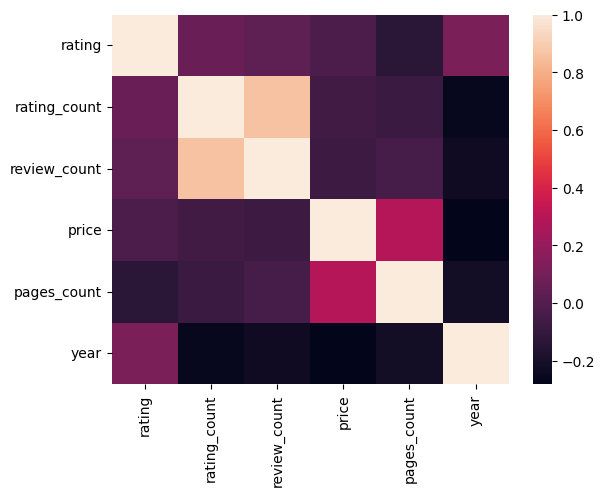

In [ ]:
sns.heatmap(corr)

Видно корелляцию между pages/price, review/rating.

Можно предложить гипотезы: чем больше насписано страниц (вложено сил?) тем дороже продаются книги? оценить книгу почти так же просто (сложно) как и написать отзыв?

Аналогично противоположные гипотезы можно сформулировать и для пар признаков с малой корреляцией



11. Постройте диаграмму рассеяния (scatterplot) количества страниц и количества отзывов. Не забудьте подписать график и оси. (1) Прокомментируйте полученные результаты. (1)


Text(0.5, 1.0, 'Scatterplot pages_count/review_count')

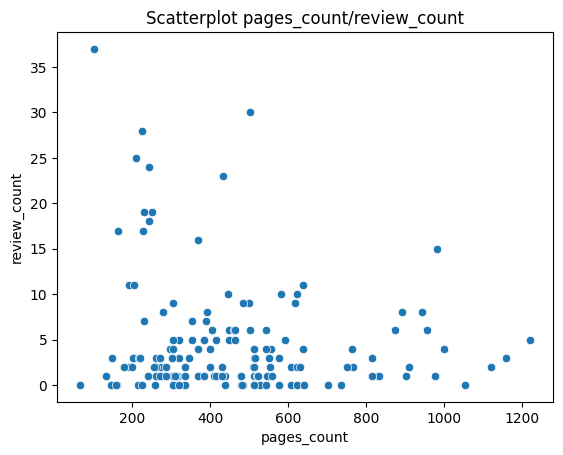

In [ ]:
g = sns.scatterplot(data=df, x="pages_count", y="review_count")
g.set_title("Scatterplot pages_count/review_count")

Явной связи между страницами и количеством отзывов не видно (разве что под влиянием того, что книг <600 страниц большинство, поэтому видно "кучкование")


12. Постройте линейный график: по оси Х год, по оси Y количество книг. (1) Прокомментируйте. (1)


Text(0.5, 1.0, 'Count of books per year')

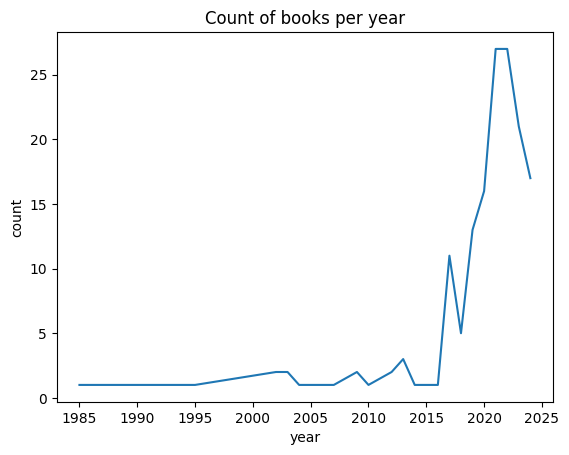

In [ ]:
g = sns.lineplot(data=df.year.value_counts().to_frame(), x="year", y="count")
g.set_title("Count of books per year")

Видно что книг с 2000-2005 годов больше в представленном датасете, что можно объяснить тем, что более новые книги легче оцифровывать или ищут новые книги скорее в интернете - от года к году.



13. Постройте еще любые два графика по вашему усмотрению. (2) Прокомментируйте полученные результаты. (1.5)

Text(0.5, 1.0, 'Rating distribution')

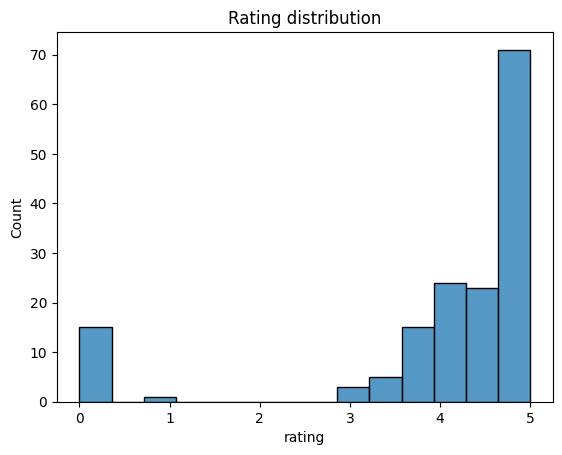

In [ ]:
g = sns.histplot(data=df, x="rating")
g.set_title("Rating distribution")

В основном книги имеют положительный рейтинг со скачком около 5

Text(0.5, 1.0, 'Price distribution')

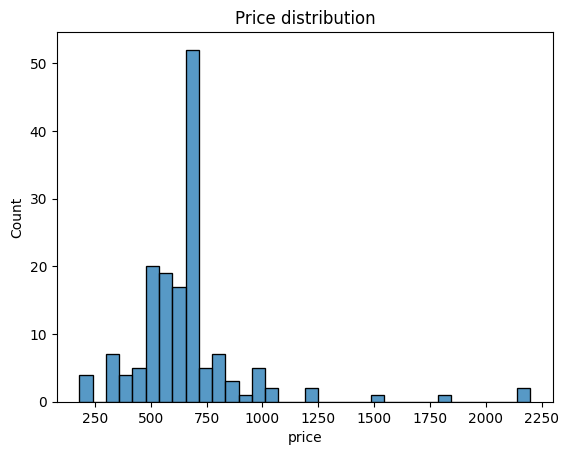

In [ ]:
g = sns.histplot(data=df, x="price")
g.set_title("Price distribution")

Очень много книг имеют цену от 600 до 700

In [ ]:
df[(600 <= df.price) & (df.price <= 700.0)].size / df.size

0.35668789808917195


14. Постройте таблицу с авторами книг с именем автора, количество книг в датасете, средней оценкой книг, средним количеством отзывов. (2).


In [ ]:
df.groupby('author').agg({'name': 'count', 'rating': 'mean', 'review_count': 'mean'})

,name,rating,review_count
author,,,
"А. А. Салахова,",1,3.8,2.0
А. В. Гриншкун,1,5.0,0.0
А. С. Степашкина,1,0.0,0.0
Алан Купер,1,4.0,30.0
Алекс Бэнкс,1,5.0,3.0
...,...,...,...
"Эрик Фримен,",1,3.9,4.0
Эрик Чоу,1,4.4,0.0
Ю. А. Винницкий,1,5.0,1.0


15. Что еще интересного можно увидеть в этом датасете? Просмотрите на данные и ответьте на какие-нибудь вопросы, на которые не ответили в предыдущим пункте. Мы никак не ограничиваем вашу фантазию! (3).

Text(0.5, 0, 'count of books')

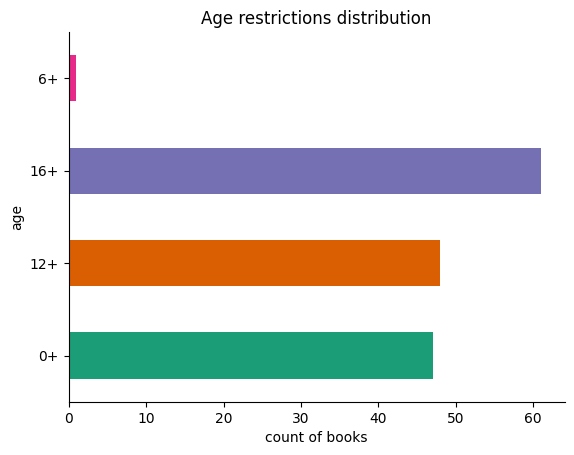

In [ ]:
# @title Распределение ограничений по возрасту

from matplotlib import pyplot as plt
import seaborn as sns
g = df.groupby('age').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
g.set_title("Age restrictions distribution")
plt.xlabel("count of books")

Практически совсем отсутствуют 6+